# Handwritten Number Recognition with TFLearn using Kaggle dataset

In this notebook, we'll be building a neural network that recognizes handwritten numbers 0-9. 

This kind of neural network is used in a variety of real-world applications including: recognizing phone numbers and sorting postal mail by address. To build the network, we'll be using the **MNIST** data set, which consists of images of handwritten numbers and their correct labels 0-9.

We'll be using [TFLearn](http://tflearn.org/), a high-level library built on top of TensorFlow to build the neural network. We'll start off by importing all the modules we'll need, then load the data, and finally build the network.

In [5]:
# Import Numpy, TensorFlow, TFLearn
import numpy as np
import tensorflow as tf
import tflearn

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Retrieving training and test data

The MNIST data set already contains both training and test data. There are 42000 data points of training data, and 28000 points of test data.

Each MNIST data point has:
1. an image of a handwritten digit and 
2. a corresponding label (a number 0-9 that identifies the image)

We'll call the images, which will be the input to our neural network, **X** and their corresponding labels **Y**.

We're going to want our labels as *one-hot vectors*, which are vectors that holds mostly 0's and one 1. It's easiest to see this in a example. As a one-hot vector, the number 0 is represented as [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], and 4 is represented as [0, 0, 0, 0, 1, 0, 0, 0, 0, 0].

### Flattened data

For this example, we'll be using *flattened* data or a representation of MNIST images in one dimension rather than two. So, each handwritten number image, which is 28x28 pixels, will be represented as a one dimensional array of 784 pixel values. 

Flattening the data throws away information about the 2D structure of the image, but it simplifies our data so that all of the training data can be contained in one array whose shape is [42000, 784]; the first dimension is the number of training images and the second dimension is the number of pixels in each image. This is the kind of data that is easy to analyze using a simple neural network.

In [10]:
import os
def get_data(train=True, base_dir='data'):
    """
    This function gets the train/test data. By default the train=True. 
    If train=False, then the test data would be returned
    output is a dataframe (train or test)
    """
    
    if train == True:
        train_data = np.loadtxt(os.path.join(base_dir,'train.csv'), delimiter=',', 
                               skiprows=1) # Skip the first row, as it is a header
        trainX = train_data[:, 1:]
        trainY = train_data[:, 0]
        return trainX, trainY
    else:
        # There are no output labels in the Kaggle dataset 
        testX = np.loadtxt(os.path.join(base_dir,'test.csv'), delimiter=',', 
                               skiprows=1) # Skip the first row, as it is a header
        return testX

In [11]:
# Retrieve the training and test data
trainX, trainY = get_data()
# Important caveat: Make sure the y-array is 2D
trainY = np.atleast_2d(trainY).T
testX = get_data(train=False)

In [13]:
# Check if the data is loaded correctly.
trainX.shape, trainY.shape, testX.shape

((42000, 784), (42000, 1), (28000, 784))

In [14]:
# Important: Make sure trainY is one-hot encoded. Which means trainY should be of shape (trainX[0], 10)
def one_hot_encoded(dataY, number_of_labels=10):
    """
    This function encodes the y-array with labels
    """
    dataY = np.atleast_1d(dataY) 
    dataY = dataY.astype(int) # Converts the labels into integer
    # Convert dataY to 1D array, flatten array
    dataY = dataY.flatten()
    encoded_matrix = np.zeros((dataY.shape[0], number_of_labels))
    encoded_matrix[np.arange(dataY.shape[0]), dataY] = 1 # Assign 1 at the taking label as the index
    
    return encoded_matrix

one_hot_encoded(trainY[:10])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [15]:
trainY = one_hot_encoded(trainY)

## Visualize the training data

Provided below is a function that will help you visualize the MNIST data. By passing in the index of a training example, the function `show_digit` will display that training image along with it's corresponding label in the title.

(42000, 784) (42000, 10)


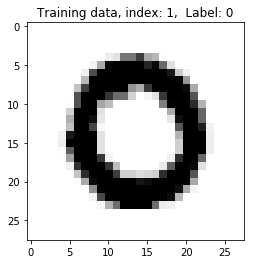

In [16]:
# Visualizing the data
import matplotlib.pyplot as plt
%matplotlib inline
print (trainX.shape, trainY.shape)
# Function for displaying a training image by it's index in the MNIST set
def show_digit(index):
    label = trainY[index].argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = trainX[index].reshape([28,28])
    plt.title('Training data, index: %d,  Label: %d' % (index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()
    
# Display the (index) training image
show_digit(1)

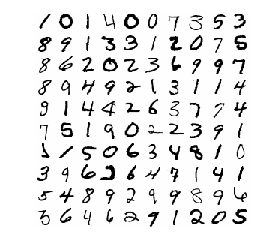

In [17]:
# Let's visualize the random 100 digits
import matplotlib.cm as cm
def display_sample_data(dataX, n_samples=100, random_points=True):
    """
    Display a sample of data in the training data set
    n_samples = Number of samples to display (this will be usually in n*n form)
    Most of the logic is borrowed from Coursera ML Octave code
    """
        
    m_length = dataX.shape[0] # Number of rows in the data
    pixel_length = dataX.shape[1] # Number of pixels in the data; this need not be in n*n form...we could have 10 x 15 pixel image as well
    
    sample_height = int(round(np.sqrt(pixel_length)))
    sample_width = int(pixel_length/sample_height)
    
    plt_rows = int(np.floor(np.sqrt(n_samples)))
    plt_cols = int(np.ceil(n_samples/plt_rows))
   
    # Padding between the images
    pad = 1
    
    # Setup a blank display
    display_array = -np.ones((pad+plt_rows*(sample_height+pad),pad+plt_rows*(sample_width+pad)))
    
    if random_points == True:
        randindices = np.random.randint(m_length, size=n_samples)# Select some n random samples from m data points (n<=m)
    else: # Select only first n points of the data
        randindices = np.arange(0, n_samples)
         
    sampleX = dataX[randindices, :] # .ix command takes indices as the argument and the dataframe is created
            
    curr_sample=0;
    for i in range(plt_rows):
        for j in range(plt_cols):
            if curr_sample > n_samples-1:
                break
            
            # Copy the patch of the pixel data
            sample_index = randindices[curr_sample]; # This is the index coming from 
            # Update the display array with the reshaped matrix
            tmp_array=np.array(dataX[sample_index,:])
            row_ll = pad + i*(sample_height + pad) + 0
            row_ul = pad + i*(sample_height + pad) + sample_height
            col_ll = pad + j*(sample_width + pad) + 0
            col_ul = pad + j*(sample_width + pad) + sample_width
            display_array[row_ll:row_ul,col_ll:col_ul] = np.reshape(tmp_array, (sample_height,sample_width))
            curr_sample += 1; # Increment
        
        # Another break statement outside for loop    
        if curr_sample > n_samples-1:
            break
    plt.style.use('ggplot');
    fig = plt.figure() # Create a fig handler
    ax = fig.add_subplot(111)
    ax.imshow(display_array,cmap=cm.binary)
    plt.axis('off')
    plt.show()
    return

# Plot the number of samples
display_sample_data(trainX, random_points=False)

## Building the network

TFLearn lets you build the network by defining the layers in that network. 

For this example, you'll define:

1. The input layer, which tells the network the number of inputs it should expect for each piece of MNIST data. 
2. Hidden layers, which recognize patterns in data and connect the input to the output layer, and
3. The output layer, which defines how the network learns and outputs a label for a given image.

Let's start with the input layer; to define the input layer, you'll define the type of data that the network expects. For example,

```
net = tflearn.input_data([None, 100])
```

would create a network with 100 inputs. The number of inputs to your network needs to match the size of your data. For this example, we're using 784 element long vectors to encode our input data, so we need **784 input units**.


### Adding layers

To add new hidden layers, you use 

```
net = tflearn.fully_connected(net, n_units, activation='ReLU')
```

This adds a fully connected layer where every unit (or node) in the previous layer is connected to every unit in this layer. The first argument `net` is the network you created in the `tflearn.input_data` call, it designates the input to the hidden layer. You can set the number of units in the layer with `n_units`, and set the activation function with the `activation` keyword. You can keep adding layers to your network by repeated calling `tflearn.fully_connected(net, n_units)`. 

Then, to set how you train the network, use:

```
net = tflearn.regression(net, optimizer='sgd', learning_rate=0.1, loss='categorical_crossentropy')
```

Again, this is passing in the network you've been building. The keywords: 

* `optimizer` sets the training method, here stochastic gradient descent
* `learning_rate` is the learning rate
* `loss` determines how the network error is calculated. In this example, with categorical cross-entropy.

Finally, you put all this together to create the model with `tflearn.DNN(net)`.

**Exercise:** Below in the `build_model()` function, you'll put together the network using TFLearn. You get to choose how many layers to use, how many hidden units, etc.

**Hint:** The final output layer must have 10 output nodes (one for each digit 0-9). It's also recommended to use a `softmax` activation layer as your final output layer. 

In [18]:
# Define the neural network
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    #### Your code ####
    # Include the input layer, hidden layer(s), and set how you want to train the model
    net = tflearn.input_data([None, trainX.shape[1]]) # trainX 
    net = tflearn.fully_connected(net, 128, activation='ReLU')
    net = tflearn.fully_connected(net, 20, activation='ReLU')
    # Add output-layer with sofmax
    net = tflearn.fully_connected(net, trainY.shape[1], activation='softmax') # There are 10 output digits
    net = tflearn.regression(net, optimizer='sgd', learning_rate=0.01, loss='categorical_crossentropy')
    
    # This model assumes that your network is named "net"    
    model = tflearn.DNN(net)
    return model

In [19]:
# Build the model
model = build_model()

## Training the network

Now that we've constructed the network, saved as the variable `model`, we can fit it to the data. Here we use the `model.fit` method. You pass in the training features `trainX` and the training targets `trainY`. Below I set `validation_set=0.1` which reserves 10% of the data set as the validation set. You can also set the batch size and number of epochs with the `batch_size` and `n_epoch` keywords, respectively. 

Too few epochs don't effectively train your network, and too many take a long time to execute. Choose wisely!

In [20]:
# Training
model.fit(trainX, trainY, validation_set=0.1, show_metric=True, batch_size=100, n_epoch=100)

Training Step: 37799  | total loss: 0.00006 | time: 2.626s
| SGD | epoch: 100 | loss: 0.00006 - acc: 1.0000 -- iter: 37700/37800
Training Step: 37800  | total loss: 0.00006 | time: 3.642s
| SGD | epoch: 100 | loss: 0.00006 - acc: 1.0000 | val_loss: 0.15531 - val_acc: 0.9752 -- iter: 37800/37800
--


## Testing
After you're satisified with the training output and accuracy, you can then run the network on the **test data set**. However we do not have the y-labels for the test data. So upload in Kaggle and see where you stand.

In [21]:
# Compare the labels that our model predicts with the actual labels

# Find the indices of the most confident prediction for each item. That tells us the predicted digit for that sample.
predictions = np.array(model.predict(testX)).argmax(axis=1)
# Output the predictions to the csv file as 
print (predictions.shape)


(28000,)


In [22]:
print (predictions[:10])
print (predictions.shape)
print (np.arange(1, predictions.shape[0]+1).shape)
#x = y = z = np.arange(0.0,5.0,1.0)
#print (x)
#np.savetxt('test.out', x, delimiter=',')   # X is an array
#np.savetxt('test.out', (x,y,z))
print (np.arange(1, predictions.shape[0]+1).reshape(predictions.shape[0], 1).shape)

[2 0 9 9 3 7 0 3 0 3]
(28000,)
(28000,)
(28000, 1)


In [93]:
np.savetxt('./results/tf_learn_output.csv', np.dstack((np.arange(1, predictions.shape[0]+1), 
                                                       predictions))[0],"%d,%d",
                                                    header='ImageId,Label', delimiter=',', comments="")

With the hyperparameters used above the score from Kaggle is: 0.97011. Not bad with a 2 hidden layer network.